In [1]:
import pandas as pd

In [8]:
# first load the building + fire data
df = pd.read_csv('third_analysis.csv')

In [9]:
# crime + census
df_crime = pd.read_csv('sf_crime_census.csv')
# link parce with blk
df_joint = pd.read_csv('parcel_blk.csv')

In [10]:
df.columns

Index(['yrbuilt', 'from_st', 'total_uses', 'shape_area', 'cie', 'landuse',
       'mips', 'mapblklot', 'objectid', 'shape_leng', 'visitor', 'st_type',
       'bldgsqft', 'resunits', 'pdr', 'street', 'retail', 'to_st', 'block_num',
       'blklot', 'lot_num', 'med', 'fire_count', 'fire_count_last year',
       'year', 'complaints_count', 'violation_count', 'building_permit'],
      dtype='object')

In [11]:
df_joint.columns

Index(['objectid', 'block_id'], dtype='object')

In [12]:
df_crime.columns

Index(['block_id', 'arson_count', 'other_crime_count', 'year',
       'nodes_population_1500m', 'block_groups_total_jobs',
       'block_groups_median_children', 'block_groups_median_income',
       'prop_tenure_1', 'nodes_low_income_hh_1500m',
       'nodes_high_income_hh_1500m', 'nodes_jobs_3000m', 'nodes_jobs_20km',
       'nodes_population_400m', 'nodes_population_800m',
       'block_groups_prop_race_of_head_1', 'block_groups_prop_race_of_head_2',
       'block_groups_prop_race_of_head_3', 'block_groups_prop_race_of_head_7',
       'block_groups_prop_race_of_head_8', 'block_groups_prop_race_of_head_6',
       'pumas_density_residential_units', 'block_groups_density_jobs',
       'nodes_jobs_1500m_4445', 'nodes_jobs_3000m_4445', 'nodes_du_5000m',
       'nodes_du_800m', 'block_groups_median_rent',
       'block_groups_median_persons', 'block_groups_median_age_of_head',
       'nodes_ave_year_built_800m'],
      dtype='object')

In [13]:
print(df_joint.shape)
print(df_crime.shape)

(158633, 2)
(173243, 31)


In [14]:
# when joining parcel with block, may resulted in duplication
df_joint.duplicated(subset=['objectid']).any()

True

In [15]:
# drop duplicate
df_joint = df_joint.drop_duplicates(subset=['objectid'], keep='first')
print(df_joint.shape)

(155466, 2)


In [16]:
print(df.shape)
# joint df with df_joint on objectid
# then join them with df_crime on block_id and year

df = df.merge(df_joint,on='objectid', how='left')
print(df.shape)

(1243744, 28)
(1243744, 29)


In [17]:
# df_crime is from 2007-2019. need to join by year and block_id
df = df.merge(df_crime,how='left',left_on=['block_id', 'year'], right_on=['block_id','year'])
print(df.shape)

(1243744, 58)


In [18]:
# select columns to use
cols_to_use = ['fire_count','fire_count_last year','year',
               'yrbuilt','bldgsqft','total_uses','cie','mips','visitor', 'pdr', 'retail', 'med','resunits',
               'complaints_count', 'violation_count','building_permit',
              'arson_count', 'other_crime_count', 
               'nodes_population_1500m', 'block_groups_total_jobs',
               'block_groups_median_children', 'block_groups_median_income',
               'prop_tenure_1', 'nodes_low_income_hh_1500m',
               'nodes_high_income_hh_1500m', 'nodes_jobs_3000m', 'nodes_jobs_20km',
               'nodes_population_400m', 'nodes_population_800m',
               'block_groups_prop_race_of_head_1', 'block_groups_prop_race_of_head_2',
               'block_groups_prop_race_of_head_3', 'block_groups_prop_race_of_head_7',
               'block_groups_prop_race_of_head_8', 'block_groups_prop_race_of_head_6',
               'pumas_density_residential_units', 'block_groups_density_jobs',
               'nodes_jobs_1500m_4445', 'nodes_jobs_3000m_4445', 'nodes_du_5000m',
               'nodes_du_800m', 'block_groups_median_rent',
               'block_groups_median_persons', 'block_groups_median_age_of_head',
               'nodes_ave_year_built_800m']

df_model = df[cols_to_use]
print(df_model.shape)
df_model = df_model.dropna(how='any')
print(df_model.shape)

(1243744, 45)
(1123981, 45)


In [19]:
df_model['fire_count'].value_counts()

0.0     1081902
1.0       36564
2.0        3637
3.0         937
4.0         409
5.0         192
6.0         132
7.0          72
8.0          38
9.0          30
10.0         25
12.0          9
11.0          8
14.0          4
19.0          3
22.0          3
16.0          3
15.0          2
18.0          2
23.0          2
27.0          1
21.0          1
32.0          1
39.0          1
37.0          1
26.0          1
30.0          1
Name: fire_count, dtype: int64

In [20]:
# make fire count binary
df_model['fire'] = 0
df_model.loc[(df_model['fire_count'] > 0),'fire'] = 1
df_model.drop('fire_count',inplace=True, axis=1)
df_model['fire'].value_counts()

#3.7% of buildings have fire

0    1081902
1      42079
Name: fire, dtype: int64

In [21]:
df_model['year'].value_counts()

2015    151875
2017    151159
2014    150959
2013    150827
2016    150563
2012    150401
2019    109392
2018    108805
Name: year, dtype: int64

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
plt.style.use('seaborn-talk')

In [119]:
# in sklearn, there are many ways of calculating accuracy of models. Use this command to display them all
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [22]:
# divide the data
x_cols = cols_to_use[1:]

validate = df_model[df_model['year']==2019]
traintest = df_model[df_model['year']<2019]

df_x = traintest[x_cols]
df_y = traintest['fire']

# a validation set used for ptrediction
validate_x = validate[x_cols]
validate_y = validate['fire']

# try random forest

In [28]:
def generate_pipeline_RC(scale=False,select=True,test_parameters=False):

    '''
    Set up modelling pipline for random forest classifier
    User selects parameters to conduct grid search and number of folds of CV
    '''

    #Scaling
    SC = StandardScaler()

    #Classifier 
    RC = RandomForestClassifier()
    #Feature selector
    FS = SelectFromModel(estimator=RC,threshold='mean')
    #Pipeline
    if (scale == True) and (select == True):
        RC_pipeline = Pipeline([('scale',SC),('select',FS),('classify', RC)])
    elif (scale == True) and (select == False):
        RC_pipeline = Pipeline([('scale',SC),('classify', RC)])
    elif (scale == False) and (select == True ):
        RC_pipeline = Pipeline([('select',FS),('classify', RC)])
    else:
        RC_pipeline = Pipeline([('classify', RC)])

    if test_parameters == False:

        #Parameters to search over
        test_parameters = {
        'classify__n_estimators': [100],
        'classify__max_depth': [15],
        'classify__min_samples_leaf':[30]
        }

    #Number of folds
    nfolds=5

    #Grid search object to set up
    grid_search = GridSearchCV(RC_pipeline, test_parameters, \
                           scoring='roc_auc',verbose=1, cv=nfolds, n_jobs=4)

    return RC_pipeline, grid_search, test_parameters

In [29]:
def perform_grid_search(pipeline_obj,grid_search_obj,X_train,y_train,test_parameters,Xcols,select=True):
    
    '''
    Perform a grid search over hyperparmeters to generate the best model. Takes a generic pipeline object and grid search
    object. Prints the length of time it takes to run a model. Runs GridSearchCV over some input range of parameters to
    select the best model based in AOC score
    '''
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline_obj.steps])
    print("parameters:")
    print(test_parameters)
    t0 = time.time()
    
    #Do the grid search on the training dataset
    grid_search_obj.fit(X_train, y_train)
    
    print("done in %0.3fs" % (time.time() - t0))
    print()

    print("Best score: %0.3f" % grid_search_obj.best_score_)
    print("Best parameters set:")
    best_estimator = grid_search_obj.best_estimator_
    best_parameters = best_estimator.get_params()
    for param_name in sorted(test_parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    #Get the names of the columns corresponding to the features we want to keep
    if select == True:
        support = best_estimator.named_steps['select'].get_support()
        X_new_cols = [Xcols[i] for i in range(len(support)) if support[i] == True]
    else:
        X_new_cols = Xcols
 
    #Return the best estimator object for use with the holdout dataset
    
    return X_new_cols, best_estimator

In [44]:
test_parameters_RF = {
        'classify__n_estimators': [100,200],
        'classify__max_depth': [10,15],
        'classify__min_samples_split':[8,20],
        'classify__min_samples_leaf':[20,30.40],
        'classify__class_weight':['balanced','balanced_subsample']
}

pipeline, gridsearch, testparams = generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

#Run grid search for the best model
Xcols, RF_model_structure = perform_grid_search(pipeline,gridsearch,df_x,df_y,testparams,list(df_x.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': [100, 200], 'classify__max_depth': [10, 15], 'classify__min_samples_split': [8, 20], 'classify__min_samples_leaf': [20, 30.4], 'classify__class_weight': ['balanced', 'balanced_subsample']}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 59.5min
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed: 234.9min finished


done in 14543.848s

Best score: 0.714
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 10
	classify__min_samples_leaf: 20
	classify__min_samples_split: 20
	classify__n_estimators: 200


Best score: 0.714
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 10
	classify__min_samples_leaf: 20
	classify__min_samples_split: 20
	classify__n_estimators: 200

In [154]:
def plot_ROC_curve(Xdata,Ytrue,model,title):

    '''
    Plot ROC curve for this model 
    '''

    fires_holdout_predict = model.predict_proba(Xdata)

    fpr, tpr, thresholds1 = roc_curve(np.array(Ytrue).astype(int), fires_holdout_predict[:,1])

    score = roc_auc_score(np.array(Ytrue).astype(int), fires_holdout_predict[:,1])

    score_label = 'AOC score: %.3f' %score 

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(fpr,tpr,label=score_label)
    ax.set_xlabel("False Positive")
    ax.set_ylabel("True Positive")
    ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')
    ax.set_title('%s' %title)

        
    ax.fill_between(fpr, np.zeros(len(fpr)),
                     tpr, alpha=0.1,
                     color="b")
    ax.grid()
    plt.legend(loc='best')
    fname = 'AOC_%s.png' %title
    plt.savefig(fname,dpi=400)

    return fig, fpr, tpr, thresholds1


In [157]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_EF = plot_ROC_curve(validate_x,validate_y,
                                                                             prediction_model,
                                                                             title='Internal_fire_ROC_RF')

ValueError: X has a different shape than during fitting.

In [33]:
# assess model performance
from sklearn import metrics

In [47]:
fprobs = RF_model_structure.predict_proba(validate_x)
fclass = RF_model_structure.predict(validate_x)
metrics.recall_score(validate_y,fclass)

0.5216326530612245

In [48]:
metrics.precision_score(validate_y,fclass)

0.1014164980359481

In [49]:
metrics.f1_score(validate_y,fclass)

0.1698169617646082

In [50]:
feature_importances = RF_model_structure.named_steps['classify'].feature_importances_
inds = feature_importances.argsort()[::-1]
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols[index])

Xcols

['fire_count_last year',
 'year',
 'yrbuilt',
 'bldgsqft',
 'total_uses',
 'resunits',
 'other_crime_count',
 'prop_tenure_1']

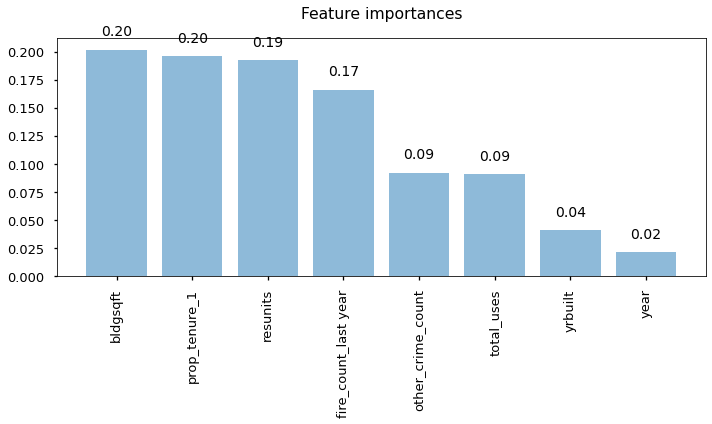

In [51]:
xlabels = fnames
ylabels = fvals

#Better label names for plot
#xlabels = ['#crimes','#external fires','Lon','Area','Lat','#inspections','#residents','year','building_age_sd','landvalue']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances",pad=20)
plt.tight_layout()
#plt.savefig("External_fires_fimportance_final.png",dpi=400)

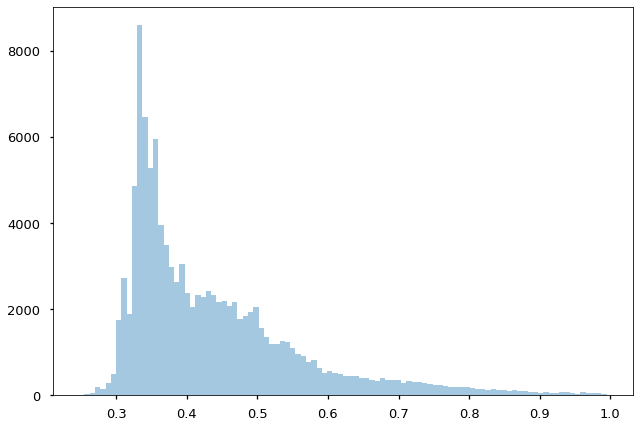

In [52]:
EF_2018_pred = RF_model_structure.predict_proba(validate_x)
#Plot the distribution of fire probabilities 
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100)

In [ ]:
filename = 'RC_model_internal.sav'
pickle.dump(RF_model_structure, open(filename, 'wb'))

In [156]:
pickle_in = open("RC_model_internal.sav", "rb")
prediction_model = pickle.load(pickle_in)

In [5]:
prediction_model

Pipeline(steps=[('select',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='mean')),
                ('classify',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_leaf=20,
                                        min_samples_split=20,
                                        n_estimators=200))])

In [7]:
pickle_in = open("premitive_model.pkl", "rb")
prediction_model = pickle.load(pickle_in)
prediction_model

GradientBoostingRegressor(criterion='mse', max_depth=18, max_features=0.3,
                          min_samples_leaf=25, n_estimators=500)

In [25]:
a = prediction_model.predict(validate_x)
a

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [43]:
validate_x

,fire_count_last year,year,yrbuilt,bldgsqft,total_uses,cie,mips,visitor,pdr,retail,...,pumas_density_residential_units,block_groups_density_jobs,nodes_jobs_1500m_4445,nodes_jobs_3000m_4445,nodes_du_5000m,nodes_du_800m,block_groups_median_rent,block_groups_median_persons,block_groups_median_age_of_head,nodes_ave_year_built_800m
1088276,0.0,2019,1912,5460,0,0,0,0,0,0,...,23.543241,17.192362,7.154541,8.253163,11.000925,6.927312,2201.1,1.0,49.0,1948.841309
1088277,0.0,2019,1900,4500,3471,0,3471,0,0,0,...,23.543241,17.192362,7.154541,8.253163,11.000925,6.927312,2201.1,1.0,49.0,1948.841309
1088278,0.0,2019,1900,5783,0,0,0,0,0,0,...,23.543241,17.192362,7.154541,8.253163,11.000925,6.927312,2201.1,1.0,49.0,1948.841309
1088279,0.0,2019,1940,3700,0,0,0,0,0,0,...,23.543241,17.192362,7.154541,8.253163,11.000925,6.927312,2201.1,1.0,49.0,1948.841309
1088280,0.0,2019,1938,4543,0,0,0,0,0,0,...,23.543241,17.192362,7.154541,8.253163,11.000925,6.927312,2201.1,1.0,49.0,1948.841309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243739,0.0,2019,1906,3440,0,0,0,0,0,0,...,11.864567,19.749188,5.605044,6.656763,10.675330,7.553971,1455.0,1.0,42.0,1946.150024
1243740,0.0,2019,1923,628,0,0,0,0,0,0,...,11.864567,879.621932,4.691154,6.292357,10.492486,7.307858,1381.0,1.0,48.5,1948.997681
1243741,0.0,2019,1956,1887,0,0,0,0,0,0,...,7.171621,0.434842,4.961212,5.794124,10.217301,7.082530,1706.0,2.0,57.0,1950.317139
1243742,0.0,2019,1921,1360,0,0,0,0,0,0,...,7.171621,4.214045,4.897986,6.326653,10.225996,7.065642,1448.0,3.0,53.0,1941.913574


In [29]:
# check the data
df_model['other_crime_count'][0]

16.0

In [30]:
df_model['prop_tenure_1'][0]

0.370786516854

In [31]:
df_model['year'][0]

2012

In [33]:
df_model['total_uses'][0]

0

In [34]:
df_model['fire_count_last year'][0]

0.0

In [57]:
fire_count_last_year = 0
year = 2019
yrbuilt = 1912 ##
bldgsqft = 5461 ##
total_uses = 0 ##
cie = 0
mips = 0
visitor = 0
pdr = 0
retail = 0
med = 0
resunits = 5 #
complaints_count = 0
violation_count = 0
building_permit = 0
arson_count = 0
other_crime_count  = 313 #
nodes_population_1500m = 0
block_groups_total_jobs = 0
block_groups_median_children = 0
block_groups_median_income = 0
prop_tenure_1 = 0.37 #
nodes_low_income_hh_1500m = 0
nodes_high_income_hh_1500m = 0
nodes_jobs_3000m = 0
nodes_jobs_20km = 0
nodes_population_400m = 0
nodes_population_800m = 0
block_groups_prop_race_of_head_1 = 0
block_groups_prop_race_of_head_2 = 0
block_groups_prop_race_of_head_3 = 0
block_groups_prop_race_of_head_7 = 0
block_groups_prop_race_of_head_8 = 0
block_groups_prop_race_of_head_6 = 0
pumas_density_residential_units = 0
block_groups_density_jobs = 0
nodes_jobs_1500m_4445 = 0
nodes_jobs_3000m_4445 = 0
nodes_du_5000m = 0
nodes_du_800m = 0
block_groups_median_rent = 0
block_groups_median_persons = 0
block_groups_median_age_of_head = 0 
nodes_ave_year_built_800m = 0

In [58]:
mode_input = [fire_count_last_year, year,
               yrbuilt,bldgsqft,total_uses,cie,mips,visitor, pdr, retail, med,resunits,
               complaints_count, violation_count,building_permit,
               arson_count, other_crime_count, 
               nodes_population_1500m, block_groups_total_jobs,
               block_groups_median_children, block_groups_median_income,
               prop_tenure_1, nodes_low_income_hh_1500m,
               nodes_high_income_hh_1500m, nodes_jobs_3000m, nodes_jobs_20km,
               nodes_population_400m, nodes_population_800m,
               block_groups_prop_race_of_head_1, block_groups_prop_race_of_head_2,
               block_groups_prop_race_of_head_3, block_groups_prop_race_of_head_7,
               block_groups_prop_race_of_head_8, block_groups_prop_race_of_head_6,
               pumas_density_residential_units, block_groups_density_jobs,
               nodes_jobs_1500m_4445, nodes_jobs_3000m_4445, nodes_du_5000m,
               nodes_du_800m, block_groups_median_rent,
               block_groups_median_persons, block_groups_median_age_of_head,
               nodes_ave_year_built_800m]


In [59]:
a = prediction_model.predict([test])
a

array([0], dtype=int64)

In [41]:
print(a)

[0]


In [61]:
validate_x.iloc[0].values

array([0.00000000e+00, 2.01900000e+03, 1.91200000e+03, 5.46000000e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.13000000e+02, 1.01908817e+01, 1.12600000e+03, 0.00000000e+00,
       1.34000000e+05, 3.70786517e-01, 7.07019234e+00, 7.57593489e+00,
       1.06838017e+01, 1.31005497e+01, 6.50727749e+00, 8.64523411e+00,
       8.53246753e-01, 7.79220779e-03, 1.29870130e-03, 1.29870130e-03,
       9.09090909e-03, 1.03896104e-01, 2.35432415e+01, 1.71923620e+01,
       7.15454102e+00, 8.25316334e+00, 1.10009251e+01, 6.92731190e+00,
       2.20110000e+03, 1.00000000e+00, 4.90000000e+01, 1.94884131e+03])

In [63]:
test_input = validate_x.iloc[0].values
b = prediction_model.predict([test_input])
b

array([1], dtype=int64)

In [65]:
b.item(0)

1

# try XGBOOST

In [99]:
import pandas as pd
# first load the building + fire data
df = pd.read_csv('third_analysis.csv')
# crime + census
df_crime = pd.read_csv('sf_crime_census.csv')
# link parce with blk
df_joint = pd.read_csv('parcel_blk.csv')
# drop duplicate
df_joint = df_joint.drop_duplicates(subset=['objectid'], keep='first')
print(df_joint.shape)
print(df.shape)
# joint df with df_joint on objectid
# then join them with df_crime on block_id and year

df = df.merge(df_joint,on='objectid', how='left')
print(df.shape)
# df_crime is from 2007-2019. need to join by year and block_id
df = df.merge(df_crime,how='left',left_on=['block_id', 'year'], right_on=['block_id','year'])
print(df.shape)


(155466, 2)
(1243744, 28)
(1243744, 29)
(1243744, 58)


In [100]:
# select columns to use
cols_to_use = ['fire_count','fire_count_last year','year',
               'yrbuilt','bldgsqft','total_uses','cie','mips','visitor', 'pdr', 'retail', 'med','resunits',
               'complaints_count', 'violation_count','building_permit',
               'arson_count', 'other_crime_count', 
               'nodes_population_1500m', 'block_groups_total_jobs','block_groups_median_income',
               'prop_tenure_1', 'pumas_density_residential_units', 'nodes_du_800m', 'block_groups_median_rent']

df_model = df[cols_to_use]
print(df_model.shape)
df_model = df_model.dropna(how='any')
print(df_model.shape)


(1243744, 25)
(1123981, 25)


In [101]:
# make fire count binary
df_model['fire'] = 0
df_model.loc[(df_model['fire_count'] > 0),'fire'] = 1
df_model.drop('fire_count',inplace=True, axis=1)
df_model['fire'].value_counts()

for cols in df_model.columns.tolist()[1:]:
    df_model = df_model.loc[df_model[cols] >= 0]  
    
# divide the data
x_cols = cols_to_use[1:]

validate = df_model[df_model['year']==2019]
traintest = df_model[df_model['year']<2019]

df_x = traintest[x_cols]
df_y = traintest['fire']

# a validation set used for ptrediction
validate_x = validate[x_cols]
validate_y = validate['fire']

print(df_model.shape)

(1123981, 25)


In [70]:
import xgboost as xgb

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features, num_features):
        self.cat_features = cat_features
        self.num_features = num_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        # Convert columns to categorical
        for name in self.cat_features:
            col = pd.Categorical(df[name])
            df[name] = col.codes
            
        # Normalize numerical features
        scaler = MinMaxScaler()
        df[self.num_features] = scaler.fit_transform(df[num_features])
        return df

In [75]:
class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_features):
        
        self.num_features = num_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
            
        # Normalize numerical features
        scaler = MinMaxScaler()
        df[self.num_features] = scaler.fit_transform(df[num_features])
        return df

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [128]:
#categorical_features = df.select_dtypes('object').columns.tolist()
#numerical_features = df.select_dtypes('int64').columns.tolist()

numerical_features = df_model.columns.tolist()
# Create a pipeline
pipe = Pipeline([('scale', MinMaxScaler()), #('preproc', PreprocessTransformer(numerical_features))  ('scale', StandardScaler()),
                 ('fs', SelectKBest()),
                 ('clf', xgb.XGBClassifier(scale_pos_weight=15,objective='binary:logistic'))
                ])

In [147]:
# Define our search space for grid search
search_space = [
    {
        'clf__n_estimators': [100,200],
        'clf__learning_rate': [0.01,0.1],
        'clf__max_depth': [15,20],
        'clf__colsample_bytree': [0.1,0.2],  #[i/10.0 for i in range(1, 3)]
        'clf__gamma': [0.1,0.2],
        'fs__score_func': [chi2],
        'fs__k': [10],
    }
]


# Define cross validation
kfold = KFold(n_splits=5, random_state=42)

# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Recall':'recall'} # 'Accuracy':make_scorer(accuracy_score)

# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
model = grid.fit(df_x, df_y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 36.8min finished


In [ ]:
from sklearn.metrics import confusion_matrix
# assess model performance
from sklearn import metrics

In [148]:
predict = model.predict(validate_x)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(validate_y, predict)))
print(confusion_matrix(validate_y,predict))

Best AUC Score: 0.7169985953313912
Accuracy: 0.9168677782653211
[[98897  5595]
 [ 3499  1401]]


In [149]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 15, 'clf__n_estimators': 200, 'fs__k': 10, 'fs__score_func': <function chi2 at 0x0000019FC46DD700>}


In [150]:
print(metrics.recall_score(validate_y,predict))
print(metrics.precision_score(validate_y,predict))
print(metrics.f1_score(validate_y,predict))

0.28591836734693876
0.20025728987993138
0.23554135843981167


In [151]:
model.best_estimator_.named_steps["clf"]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=15, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
filename = 'XGBoost_internal.sav'
pickle.dump(model, open(filename, 'wb'))

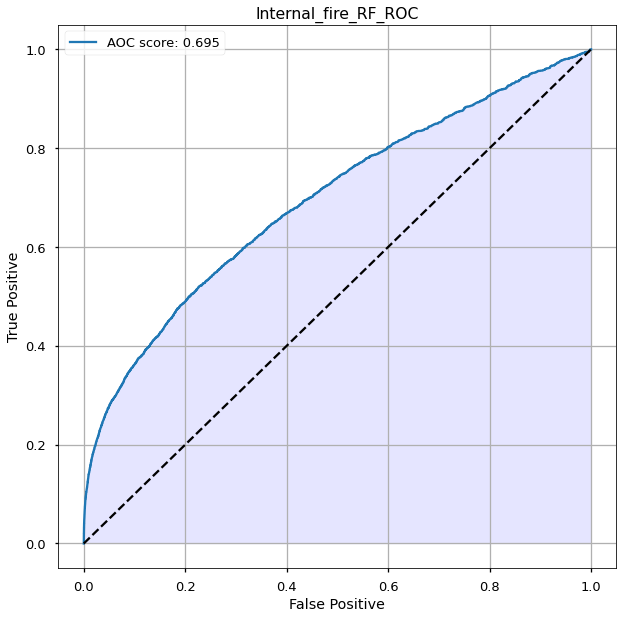

In [158]:
ROCplot, false_positive_XGBOOST, true_positive_XGBOOST, thresholds_XGBOOST = plot_ROC_curve(validate_x,validate_y,
                                                                             model,
                                                                             title='Internal_fire_RF_ROC')